In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
sample_size=2000
total_sample_size=4000

In [3]:
pd.options.display.max_columns = 200

In [4]:
df = pd.read_csv("data/cleaned.csv")

In [5]:
df.rename(columns={"Unnamed: 0": "Respondent"}, inplace=True)

In [6]:
df.set_index("Respondent", inplace=True)

In [7]:
df["Hobbyist"].replace({"Yes": 1, "No": 0}, inplace=True)

In [8]:
df.head()

,"EdLevel_Bachelor’s degree (B.A., B.S., B.Eng., etc.)",EdLevel_I never completed any formal education,"EdLevel_Master’s degree (M.A., M.S., M.Eng., MBA, etc.)","EdLevel_Other doctoral degree (Ph.D., Ed.D., etc.)",EdLevel_Primary/elementary school,"EdLevel_Professional degree (JD, MD, etc.)","EdLevel_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)",EdLevel_Some college/university study without earning a degree,EdLevel_isNaN,Employment_Employed part-time,"Employment_Independent contractor, freelancer, or self-employed","Employment_Not employed, and not looking for work","Employment_Not employed, but looking for work",Employment_Retired,Employment_Student,Employment_isNaN,OrgSize_10 to 19 employees,"OrgSize_10,000 or more employees",OrgSize_100 to 499 employees,OrgSize_2 to 9 employees,OrgSize_20 to 99 employees,"OrgSize_5,000 to 9,999 employees",OrgSize_500 to 999 employees,"OrgSize_Just me - I am a freelancer, sole proprietor, etc.",OrgSize_isNaN,Sexuality_Bisexual;Gay or Lesbian,Sexuality_Bisexual;Gay or Lesbian;Queer,Sexuality_Bisexual;Gay or Lesbian;Straight / Heterosexual,Sexuality_Bisexual;Gay or Lesbian;Straight / Heterosexual;Queer,Sexuality_Bisexual;Queer,Sexuality_Bisexual;Straight / Heterosexual,Sexuality_Bisexual;Straight / Heterosexual;Queer,Sexuality_Gay or Lesbian,Sexuality_Gay or Lesbian;Queer,Sexuality_Gay or Lesbian;Straight / Heterosexual,Sexuality_Queer,Sexuality_Straight / Heterosexual,Sexuality_Straight / Heterosexual;Queer,Sexuality_isNaN,"UndergradMajor_A health science (such as nursing, pharmacy, radiology, etc.)","UndergradMajor_A humanities discipline (such as literature, history, philosophy, etc.)","UndergradMajor_A natural science (such as biology, chemistry, physics, etc.)","UndergradMajor_A social science (such as anthropology, psychology, political science, etc.)","UndergradMajor_Another engineering discipline (such as civil, electrical, mechanical, etc.)","UndergradMajor_Computer science, computer engineering, or software engineering","UndergradMajor_Fine arts or performing arts (such as graphic design, music, studio art, etc.)",UndergradMajor_I never declared a major,"UndergradMajor_Information systems, information technology, or system administration",UndergradMajor_Mathematics or statistics,UndergradMajor_Web development or web design,UndergradMajor_isNaN,DatabaseDesireNextYear_is_MariaDB,DatabaseDesireNextYear_is_Cassandra,DatabaseDesireNextYear_is_Elasticsearch,DatabaseDesireNextYear_is_Microsoft SQL Server,DatabaseDesireNextYear_is_MySQL,DatabaseDesireNextYear_is_Couchbase,DatabaseDesireNextYear_is_Firebase,DatabaseDesireNextYear_is_isNaN,DatabaseDesireNextYear_is_IBM DB2,DatabaseDesireNextYear_is_PostgreSQL,DatabaseDesireNextYear_is_DynamoDB,DatabaseDesireNextYear_is_MongoDB,DatabaseDesireNextYear_is_Redis,DatabaseDesireNextYear_is_SQLite,DatabaseDesireNextYear_is_Oracle,DatabaseWorkedWith_is_MariaDB,DatabaseWorkedWith_is_Elasticsearch,DatabaseWorkedWith_is_Cassandra,DatabaseWorkedWith_is_Microsoft SQL Server,DatabaseWorkedWith_is_MySQL,DatabaseWorkedWith_is_Couchbase,DatabaseWorkedWith_is_Firebase,DatabaseWorkedWith_is_isNaN,DatabaseWorkedWith_is_IBM DB2,DatabaseWorkedWith_is_PostgreSQL,DatabaseWorkedWith_is_DynamoDB,DatabaseWorkedWith_is_MongoDB,DatabaseWorkedWith_is_Redis,DatabaseWorkedWith_is_SQLite,DatabaseWorkedWith_is_Oracle,DevType_is_Designer,DevType_is_Academic researcher,"DevType_is_Developer, game or graphics","DevType_is_Developer, embedded applications or devices",DevType_is_Data scientist or machine learning specialist,DevType_is_Database administrator,DevType_is_Data or business analyst,DevType_is_System administrator,DevType_is_Scientist,DevType_is_Senior executive/VP,DevType_is_Product manager,"DevType_is_Engineer, data",DevType_is_Educator,DevType_is_Marketing or sales professional,"DevType_is_Developer, front-end","DevType_is_Engineer, site reliability",DevType_is_Engineering manager,"DevType_is_Developer, desktop or enterprise applic

In [9]:
df.Hobbyist.value_counts()

1    50388
0    14028
Name: Hobbyist, dtype: int64

In [10]:
balanced = pd.concat([
    df[df.Hobbyist == 0].sample(sample_size, random_state=42),
    df[df.Hobbyist == 1].sample(sample_size, random_state=42)
])

### Feature Selection And Initial Modeling

In [11]:
from sklearn.preprocessing import StandardScaler, Normalizer
from sklearn.feature_selection import SelectKBest, chi2, f_classif, VarianceThreshold

from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer

In [12]:
x = df.drop("Hobbyist", axis=1).sample(total_sample_size, random_state=42)
y = df["Hobbyist"].sample(total_sample_size, random_state=42)

In [13]:
x_train, x_test, y_train, y_test = train_test_split(x,y,test_size=0.2, random_state=42)

In [14]:
df.select_dtypes(include=["float"]).isna().sum()

Age              18970
Age1stCode        6516
CompTotal        29590
ConvertedComp    29660
WorkWeekHrs      23265
YearsCode         6732
YearsCodePro     18067
dtype: int64

In [15]:
pipeline = Pipeline([
    ('imputer', SimpleImputer()),
    ('scaler', StandardScaler()),
    ("variance", VarianceThreshold(threshold=0.25)),
    ('selector', SelectKBest()),
    ('classifier', KNeighborsClassifier())
])

In [16]:
search_space = [
                {'selector__k': [3, 5, 6, 7, 4],
                 'classifier': [LogisticRegression(solver='lbfgs')],
                 'classifier__C': [0.01, 0.1, 1.0]},
                {'selector__k': [10, 5, 20, 30],
                 'classifier': [RandomForestClassifier()],
                 'classifier__n_estimators': np.linspace(50,250,5, dtype=int),
                 'classifier__max_depth': [5, 10, None]},
                {'selector__k': [10, 5, 20, 30],
                 'classifier': [KNeighborsClassifier()],
                 'classifier__n_neighbors': [3, 7, 11],
                 'classifier__weights': ['uniform', 'distance']}]

In [17]:
acc_score = make_scorer(accuracy_score)

In [18]:
clf = RandomizedSearchCV(pipeline, search_space, scoring=acc_score, cv=5)

In [19]:
clf.fit(x_train, y_train)

RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('imputer', SimpleImputer()),
                                             ('scaler', StandardScaler()),
                                             ('variance',
                                              VarianceThreshold(threshold=0.25)),
                                             ('selector', SelectKBest()),
                                             ('classifier',
                                              KNeighborsClassifier())]),
                   param_distributions=[{'classifier': [LogisticRegression(C=0.1)],
                                         'classifier__C': [0.01, 0.1, 1.0],
                                         'selector__k': [3, 5, 6, 7, 4]},
                                        {'classifier': [RandomForestClassifier()],
                                         'classifier__max_depth': [5, 10, None],
                                         'classifier__n_estimators': array([ 50,

In [20]:
y_pred = clf.predict(x_test)
score = accuracy_score(y_pred,y_test)
score

0.76875

In [21]:
clf.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', StandardScaler()),
                ('variance', VarianceThreshold(threshold=0.25)),
                ('selector', SelectKBest(k=4)),
                ('classifier', LogisticRegression(C=0.1))])

In [22]:
kbest = clf.best_estimator_.named_steps['selector']

In [23]:
feature_indices = kbest.get_support(indices=True)

In [24]:
features = [df.columns[i] for i in feature_indices]

In [25]:
features

['DatabaseDesireNextYear_is_Redis',
 'LanguageDesireNextYear_is_PHP',
 'NEWSOSites_is_Stack Overflow Advertising (for technology companies)',
 'PlatformDesireNextYear_is_Raspberry Pi']

### Now we have a list of features to explore
We also have a baseline model accuracy of 64% which we will improve upon once we explore important features, do feature engineering and model optimization

In [26]:
#Lets read in our original data frame
original_df = pd.read_csv("Data/Survey_results_public.csv", index_col="Respondent")
schema = pd.read_csv("Data/Survey_results_schema.csv", index_col="Column")

In [27]:
schema.sample(20)

,QuestionText
Column,
NEWLearn,How frequently do you learn a new language or ...
SurveyEase,How easy or difficult was this survey to compl...
NEWJobHunt,"In general, what drives you to look for a new ..."
NEWOnboardGood,Do you think your company has a good onboardin...
YearsCodePro,"NOT including education, how many years have y..."
DevType,Which of the following describe you? Please se...
OpSys,What is the primary operating system in which ...
WelcomeChange,"Compared to last year, how welcome do you feel..."
Hobbyist,Do you code as a hobby?


In [28]:
#lets look at reported work week hours vs hobbyists
schema.loc['UndergradMajor'].QuestionText

'What was your primary field of study?'

# Features to Explore
<ol>
    <li>JobSat</li>
    <li>Employment</li>
    <li>Gender</li>
    <li>JobSat</li>
    <li>DevType</li>
    <li>LanguageDesireNextYear</li>
    <li>MiscTechDesireNextYear</li>
    <li>PlatformDesireNextYear</li>
</ol>

In [29]:
#Lets start with Job Satisfaction

JobSat_col_names = []
for i in df.columns:
    if i.startswith("JobSat"):
        JobSat_col_names.append(i)
JobSat_col_names

['JobSat_Slightly dissatisfied',
 'JobSat_Slightly satisfied',
 'JobSat_Very dissatisfied',
 'JobSat_Very satisfied',
 'JobSat_isNaN']

In [34]:
#Make a Seaborn barplot showing the number of hobbyists in each category  
def to_explore_df(dframe, prefix, dependent_var, add_dropped):
    
    ## create column nameslist
    col_names = []
    for i in dframe.columns:
        if i.startswith(prefix):
            col_names.append(i)
    
    ##create mini dataframe
    mini_df = dframe.loc[:,col_names]
    
    #create new series called last category if all columns are 0 than 1 else 0
    if add_dropped:
        col_name = prefix + "_MissingCategory"
        mini_df[col_name] = mini_df.sum(axis=1) - 1
        mini_df[col_name].replace({-1:1}, inplace=True)
    
    
    #for each column
    for i in mini_df.columns:     
        
        #split string on the prefix
        split = len(prefix) + 1
        val = i[split:]
        
        #replace ones with the string that comes after the prefix and 0's with np.nan
        mini_df[i].replace({0: np.nan, 1: val}, inplace=True)
    
    
    #merge all columns on respondent
    series_df=pd.DataFrame()
    
    
    for i in mini_df.columns:
        series_df = pd.concat([series_df, mini_df[i]])
    
    series_df.dropna(inplace=True)
    series_df.reset_index(inplace=True)
    series_df.columns = ["Respondent", prefix]
    
    missingCat = pd.DataFrame(series_df)
    dependent_df = pd.DataFrame(dframe[dependent_var]).reset_index()
    
    return_df = missingCat.merge(dependent_df, on="Respondent", how="outer")
    return_df.set_index("Respondent", inplace=True)
    return_df.columns=[prefix, dependent_var]
    
    
    return return_df
    
viz_df = to_explore_df(balanced, "JobSat", "Hobbyist", True)

In [35]:
viz_df

,JobSat,Hobbyist
Respondent,,
50540,Slightly dissatisfied,0
33412,Slightly dissatisfied,0
12604,Slightly dissatisfied,0
43145,Slightly dissatisfied,0
60796,Slightly dissatisfied,0
...,...,...
45248,MissingCategory,1
37974,MissingCategory,1
17197,MissingCategory,1


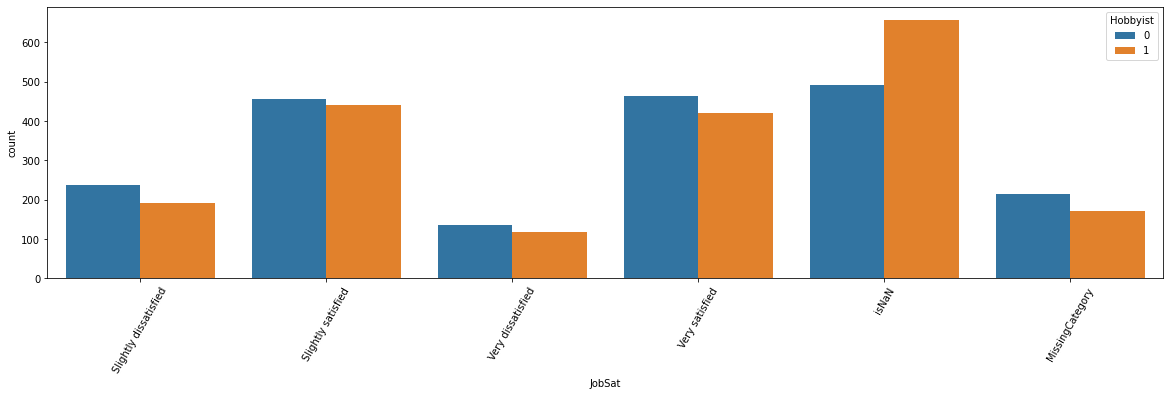

In [37]:
ax, fig = plt.subplots(figsize=(20,5))

sns.countplot(data=viz_df, x="JobSat", hue="Hobbyist")
plt.xticks(rotation=60)

plt.show()